### Notebook to reformat raw 10X matrices into anndata for project `23-0092` prior to `cellbender`

- **Developed by:** Carlos Talavera-López Ph.D
- **Würzburg Institute for Systems Immunology & Julius-Maximilian-Universität Würzburg**
- v230828

### Import required modules

In [10]:
import anndata
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

### Set up working environment

In [11]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.8.0
scanpy      1.9.3
-----
PIL                 9.4.0
appnope             0.1.3
asttokens           NA
backcall            0.2.0
cffi                1.15.1
colorama            0.4.6
comm                0.1.2
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.6
decorator           5.1.1
executing           1.2.0
h5py                3.8.0
igraph              0.10.4
importlib_resources NA
ipykernel           6.21.2
ipywidgets          8.0.7
jedi                0.18.2
joblib              1.2.0
kiwisolver          1.4.4
leidenalg           0.9.1
llvmlite            0.39.1
louvain             0.8.0
matplotlib          3.7.0
matplotlib_inline   0.1.6
mpl_toolkits        NA
natsort             8.2.0
numba               0.56.4
numexpr             2.8.4
numpy               1.23.5
packaging           23.0
pandas              1.5.3
parso               0.8.3
pexpect             4.8.0
pickleshare         0.7.5
pkg_resources       N

In [12]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis = 0))

### Read in samples

In [13]:
sample_metadata = pd.read_csv('../data/Sample_Genotype.csv', sep = ',', index_col = 0)
sample_metadata.columns = ['genotype']
sample_metadata.head()

,genotype
Sample,
A9_2,WT
A10_2,WT
A11_2,Mdx
A12_2,Mdx
B1_2,MdxSCID


In [14]:
path = '../data/'
filenames = sample_metadata.index
adatas = [sc.read_10x_mtx(path + filename + '/raw_feature_bc_matrix/') for filename in filenames]
for i in range(len(adatas)):
    adatas[i].obs['sample'] = sample_metadata.index[i]
    for col in sample_metadata.columns:
        adatas[i].obs[col] = sample_metadata[col][i]
adata = adatas[0].concatenate(adatas[1:], batch_categories = sample_metadata.index)
adata.shape

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


/Users/cartalop/mambaforge/envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/Users/cartalop/mambaforge/envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/Users/cartalop/mambaforge/envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float6

(10055673, 32285)

In [16]:
adata.obs['sample'] = adata.obs['sample'].astype('category')
adata.obs['sample'].cat.categories

Index(['A10_2', 'A11_2', 'A12_2', 'A9_2', 'B1_2', 'B2_2'], dtype='object')

In [17]:
adata.obs['genotype'] = adata.obs['genotype'].astype('category')
adata.obs['genotype'].cat.categories

Index(['Mdx', 'MdxSCID', 'WT'], dtype='object')

In [18]:
X_is_raw(adata)

True

### Save merged object

In [19]:
adata.write('../data/heart_mm_nuclei-23-0092_ctl230828.raw.h5ad')

### Split object into individual samples for `cellbender`

In [35]:
adata.layers['counts'] = adata.X.copy()

In [36]:
sample_names = adata.obs['sample'].unique()

for sample_name in sample_names:
    mask = adata.obs['sample'] == sample_name
    sample_adata = adata[mask].copy()
    
    output_filename = f'{sample_name}_mm_nuclei-23-0092_ctl230828.raw.h5ad'
    sample_adata.write(path + output_filename)

### Generate UMI knee plot per sample

/var/folders/rx/f17v355x1xqdpm4hlmym_zvw0000gn/T/ipykernel_99569/2965541337.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap('tab10')


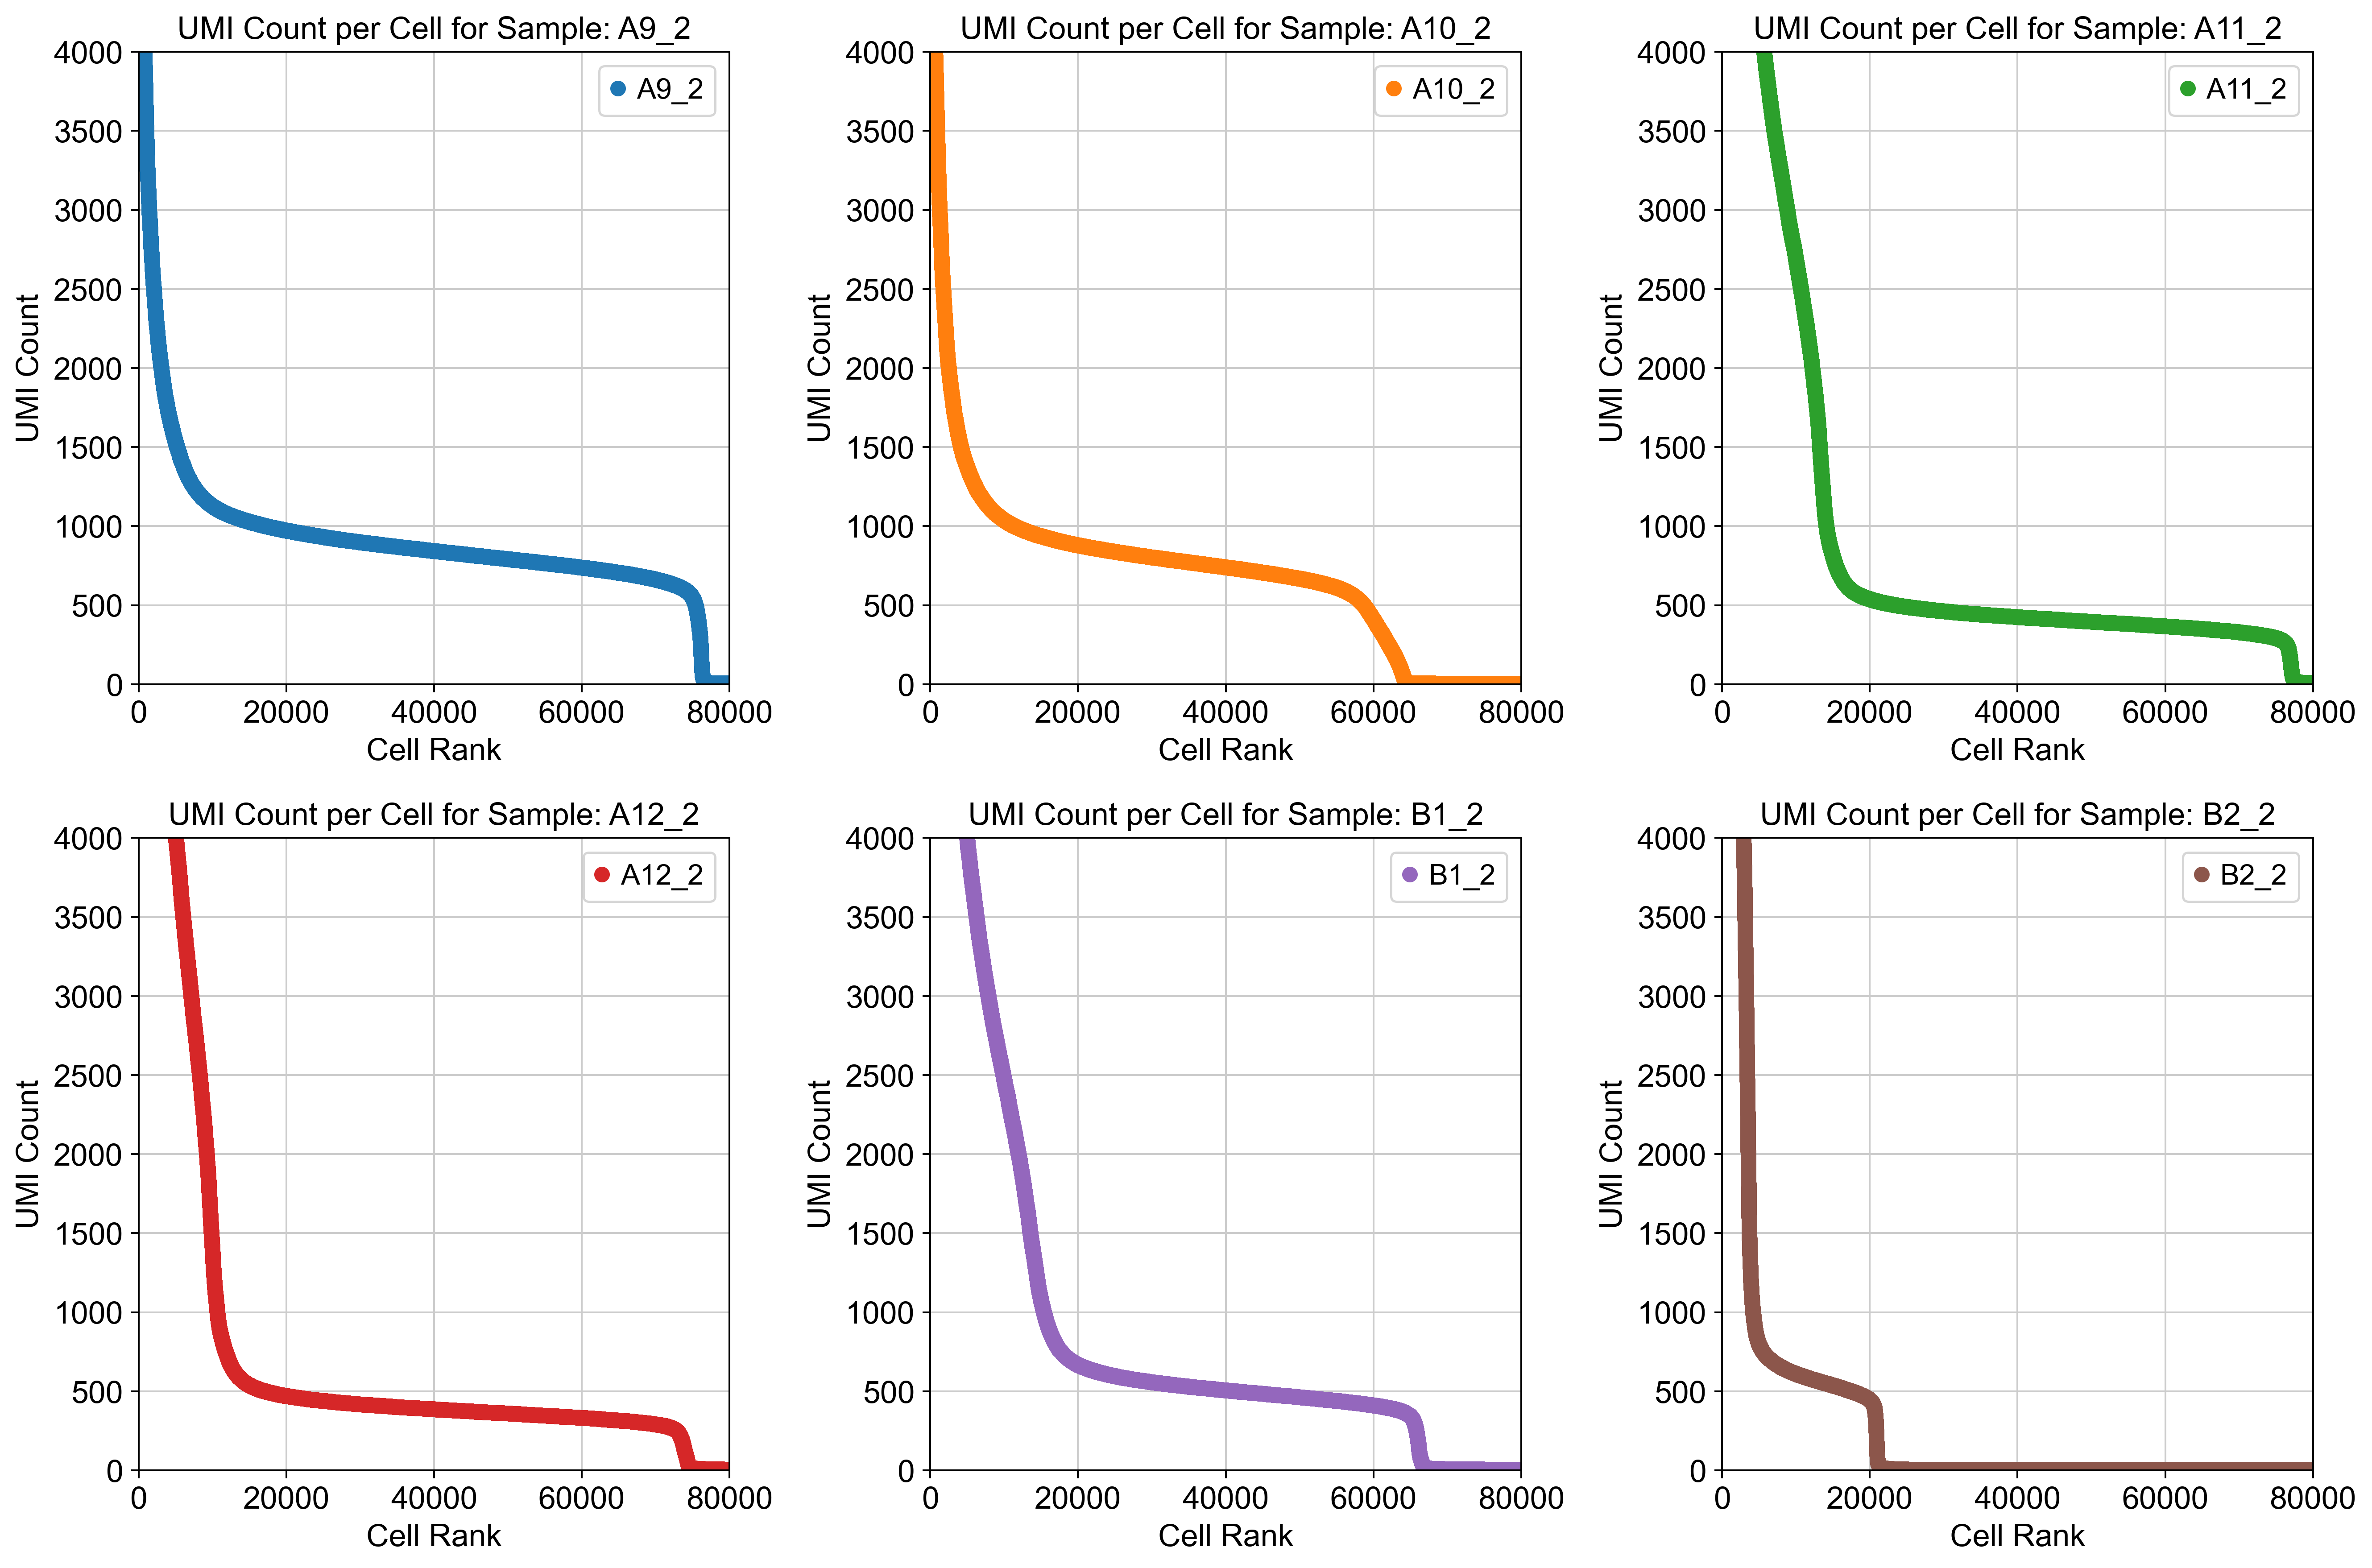

In [34]:
sample_names = adata.obs['sample'].unique()

num_rows = 2
num_cols = 3
fig, axs = plt.subplots(num_rows, num_cols, figsize = (15, 10))
axs = axs.flatten()
color_palette = plt.cm.get_cmap('tab10')

for idx, sample_name in enumerate(sample_names):
    mask = adata.obs['sample'] == sample_name
    sample_adata = adata[mask].copy()

    sample_adata.obs['umi_counts'] = sample_adata.X.sum(axis = 1)
    sample_adata = sample_adata[sample_adata.obs['umi_counts'].argsort()[::-1]]

    ax = axs[idx]
    color = color_palette(idx)
    ax.plot(range(1, len(sample_adata) + 1), sample_adata.obs['umi_counts'], marker = 'o', linestyle = '-', label = sample_name, color = color, linewidth = 0.2)
    ax.set_xlabel('Cell Rank')
    ax.set_ylabel('UMI Count')
    ax.set_title(f'UMI Count per Cell for Sample: {sample_name}')
    ax.set_xlim(0, 80000)
    ax.set_ylim(0, 4000)  # Set x-axis limit
    ax.legend()

plt.tight_layout()
output_filename = 'umi_count_subplot.png'
plt.savefig(output_filename)

plt.show()
